# rG4Seeqer data analysis

Whats this notebook about?

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


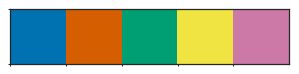

In [1]:
import sys
import os
from glob import glob
import re
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

%env KERAS_BACKEND tensorflow
from keras import layers, models, callbacks, optimizers
from keras.utils import HDF5Matrix
import h5py

from g4seeqer.g4hunter import windowed_g4hunter
from g4seeqer.filter import filter_g4s, cluster_overlapping
from g4seeqer.neuralnet import one_hot_sequence, decode_ohe, load_model
from g4seeqer import mutmap

## Default plotting params

pd.set_option('display.max_rows', 250)

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method="merge-exons" \
  -I /home/matthew/iceberg_shared/General/annotations/hg19_ensembl75/geneset_exons.gtf.gz \
  -L /dev/stderr > ./data/hg19_merged_exons.gtf

Process is terminated.


In [3]:
!head ./data/hg19_g4hunter.bed

chr1	9965	10093	g4h	1.52	-
chr1	10095	10223	g4h	1.56	-
chr1	10245	10373	g4h	2.42	-
chr1	10380	10508	g4h	1.60	-
chr1	10760	10888	g4h	0.92	+
chr1	10890	11018	g4h	0.84	+
chr1	11020	11148	g4h	1.12	+
chr1	11095	11223	g4h	0.80	-
chr1	11225	11353	g4h	0.90	+
chr1	11235	11363	g4h	0.82	-


In [4]:
%%bash
bedtools intersect -u -s \
  -a data/hg19_g4hunter.bed \
  -b data/hg19_merged_exons.gtf \
  -f 1 > data/hg19_g4hunter_exonic.bed

In [5]:
%%bash
bedtools fisher -g data/hg19.chrom.sizes -s -F 0.75 \
  -a data/hg19_g4hunter_exonic.bed \
  -b <(zcat data/rG4seeqer/GSE77282_K_hits.bed.gz | sort -k1,1 -k2,2n)

# Number of query intervals: 186279
# Number of db intervals: 3383
# Number of overlaps: 2811
# Number of possible intervals (estimated): 16369573
# phyper(2811 - 1, 186279, 16369573 - 186279, 3383, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 2811         | 183468       |
# not in -a | 572          | 16182722     |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	0	0	433.467


In [6]:
%%bash
bedtools map -c 5 -o max -F 0.75 -s \
  -a data/hg19_g4hunter_exonic.bed \
  -b <(zcat data/rG4seeqer/GSE77282_K_hits.bed.gz | sort -k1,1 -k2,2n) \
> data/hg19_g4hunter_rG4_labelled.bed

In [7]:
!head data/hg19_g4hunter_rG4_labelled.bed

chr1	12020	12148	g4h	0.84	+	.
chr1	13605	13733	g4h	0.84	+	.
chr1	14250	14378	g4h	0.92	+	.
chr1	14450	14578	g4h	1.14	-	.
chr1	29550	29678	g4h	1.04	-	.
chr1	29660	29788	g4h	1.06	+	.
chr1	35830	35958	g4h	1.16	-	.
chr1	69435	69563	g4h	0.76	+	.
chr1	89810	89938	g4h	0.96	-	.
chr1	89965	90093	g4h	0.84	-	.


In [8]:
rg4_data = pd.read_table(
    './data/hg19_g4hunter_rG4_labelled.bed', sep='\t',
    names=['chrom', 'start', 'end', '_', 'g4h_score', 'strand', 'rG4_score'],
    usecols=['chrom', 'start', 'end', 'g4h_score', 'rG4_score', 'strand'],
    na_values='.'
).fillna(0)
rg4_data.head()

,chrom,start,end,g4h_score,strand,rG4_score
0,chr1,12020,12148,0.84,+,0.0
1,chr1,13605,13733,0.84,+,0.0
2,chr1,14250,14378,0.92,+,0.0
3,chr1,14450,14578,1.14,-,0.0
4,chr1,29550,29678,1.04,-,0.0


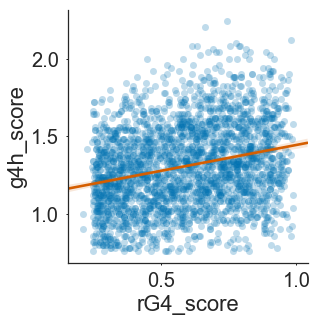

In [9]:
sns.lmplot(x='rG4_score',
           y='g4h_score',
           data=rg4_data[rg4_data.rG4_score != 0],
           scatter_kws={'alpha': 0.25, 'color': pal[0], 'rasterized': True},
           line_kws={'color': pal[1]}
)
plt.show()

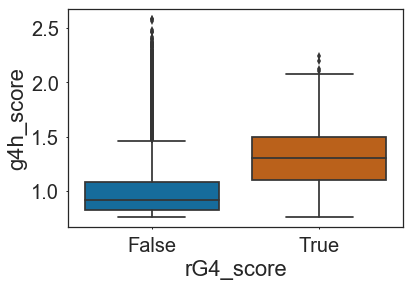

In [10]:
sns.boxplot(
    x=rg4_data.rG4_score != 0,
    y=rg4_data.g4h_score
)
plt.show()

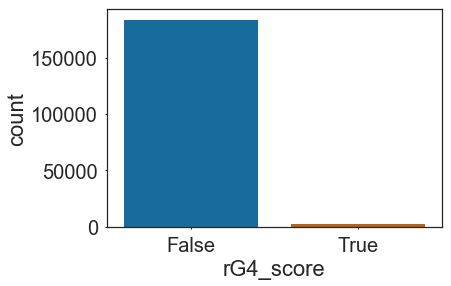

In [11]:
sns.countplot(rg4_data.rG4_score != 0)
plt.show()

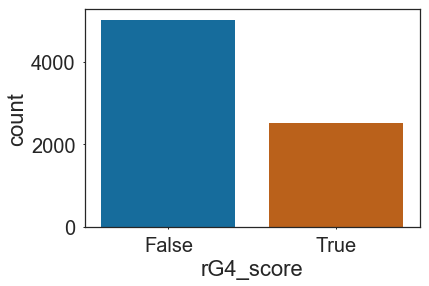

In [12]:
def ratio(y):
    return {0: int(2 * y.sum()), 1: int(y.sum())}

rus = RandomUnderSampler(ratio=ratio)
idx, y_resampled = rus.fit_sample(np.arange(len(rg4_data)).reshape(-1, 1),
                                  rg4_data.rG4_score != 0)
rg4_data_resampled = rg4_data.iloc[idx.ravel()]
sns.countplot(rg4_data_resampled.rG4_score != 0)
plt.show()

In [13]:
len(rg4_data_resampled) * 0.9

6766.2

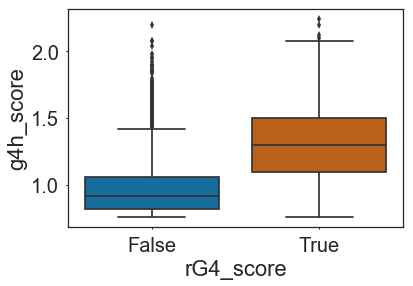

In [14]:
sns.boxplot(
    x=rg4_data_resampled.rG4_score != 0,
    y=rg4_data_resampled.g4h_score
)
plt.show()

In [15]:
len(rg4_data_resampled)

7518

In [16]:
rg4_data_resampled.to_csv(
    './data/hg19_g4h_rg4_resampled.tmp.bed', sep='\t',
    columns=['chrom', 'start', 'end', 'g4h_score', 'rG4_score', 'strand'],
    header=False,
    index=False,
)
!shuf ./data/hg19_g4h_rg4_resampled.tmp.bed > ./data/hg19_g4h_rg4_resampled.bed
!rm ./data/hg19_g4h_rg4_resampled.tmp.bed
!head ./data/hg19_g4h_rg4_resampled.bed

chr11	59969005	59969133	0.84	0.0	-
chr17	8045635	8045763	1.62	0.5835736311	-
chr16	18485950	18486078	0.76	0.0	-
chr12	53839940	53840068	0.94	0.0	+
chr19	5153140	5153268	1.82	0.6299510681	+
chr19	49148845	49148973	1.68	0.5103020117	-
chr12	48541805	48541933	1.16	0.7429851686	-
chr10	98720745	98720873	1.32	0.8023043515	+
chr9	124991090	124991218	1.92	0.0	-
chr19	47569645	47569773	0.82	0.0	-


In [17]:
%%bash
bedtools getfasta -s -tab\
  -fi /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -bed ./data/hg19_g4h_rg4_resampled.bed \
  -fo stdout | paste ./data/hg19_g4h_rg4_resampled.bed - | \
cut -f1-6,8 > ./data/hg19_g4h_rg4_seq.bed
head ./data/hg19_g4h_rg4_seq.bed | cut -c-80

chr11	59969005	59969133	0.84	0.0	-	aagtgaggagcgtctctgcccggctgccatcccatctaggaagtg
chr17	8045635	8045763	1.62	0.5835736311	-	CAGCCACACAAGCAAATACTTTGGCAGCATCGACTCTT
chr16	18485950	18486078	0.76	0.0	-	GGACCCCGGAGAACGGCAGCGAGCCTGAGAGCAGGTCCCCGGACA
chr12	53839940	53840068	0.94	0.0	+	CCCCACCCCCTACCTCCACCTGAGCCTCACCCTGCTGTTGAGCCC
chr19	5153140	5153268	1.82	0.6299510681	+	AGTGTTACGCAGGAGCAAGCCTTTCATTTCCTTGGTGG
chr19	49148845	49148973	1.68	0.5103020117	-	GACAGGGTCCCAGAAGGAGGGGACAGAGGAGCTGAG
chr12	48541805	48541933	1.16	0.7429851686	-	TGTTCTGGAACCTTTGCTTTTTATTGATTTATACAA
chr10	98720745	98720873	1.32	0.8023043515	+	CCTGTAACACAACACTGTAGCTATAAACTCTAAGTG
chr9	124991090	124991218	1.92	0.0	-	ggcagcggcggcagcagccagggaggccggggctgcgcgcgggc
chr19	47569645	47569773	0.82	0.0	-	CCGTGCCCACCCTCTTCGGGACGGTGAAGCAGACACCCAAGACGG


In [18]:
import itertools as it

TRINUCLS = [''.join(t) for t in it.product('ACGT', repeat=3)]
TRINUCLS.append('NNN')

def trinucl_composition(seq):
    seq = seq.upper()
    trinucls = {k: 0 for k in TRINUCLS}
    for i in range(len(seq) - 2):
        try:
            trinucls[seq[i: i + 3]] += 1
        except:
            trinucls['NNN'] += 1
    trinucls = np.array([trinucls[t] for t in TRINUCLS])
    return trinucls / trinucls.sum()


seq_ohe = {'A': [1, 0, 0, 0],
           'C': [0, 1, 0, 0],
           'G': [0, 0, 1, 0],
           'T': [0, 0, 0, 1],
           'N': [0, 0, 0, 0]}


def one_hot_sequence(seq):
    ohe = []
    seq = seq.upper()
    if len(seq) < 128:
        seq = seq + 'N' * (128 - len(seq))
    for base in seq:
        try:
            ohe.append(seq_ohe[base])
        except KeyError:
            ohe.append(seq_ohe['N'])
    return np.asarray(ohe)


def load_data(data_fn, chrom_sizes, h5_fn, chunksize=1000):
    length = !wc -l {data_fn}
    length = int(length[0].split()[0])
    with open(chrom_sizes) as f:
        ref_names = [line.split('\t')[0].encode('utf-8') for line in f.readlines()]
        ref_id_map = {name: i for i, name in enumerate(ref_names)}
    with h5py.File(h5_fn, 'w') as h5_file:
        X = h5_file.create_dataset('X',
                                   shape=(length, 128, 4),
                                   dtype=np.uint8,
                                   chunks=(chunksize, 128, 4))
        X_trinucl = h5_file.create_dataset('X_trinucl',
                                           shape=(length, len(TRINUCLS)),
                                           dtype=np.float32,
                                           chunks=(chunksize, len(TRINUCLS)))
        y = h5_file.create_dataset('y',
                                   shape=(length, ),
                                   dtype=np.float32,
                                   chunks=(chunksize, ))
        y_cat = h5_file.create_dataset('y_cat',
                                       shape=(length,),
                                       dtype=np.uint8,
                                       chunks=(chunksize,))
        g4h = h5_file.create_dataset('g4h',
                                     shape=(length, ),
                                     dtype=np.float32,
                                     chunks=(chunksize, ))
        ref_ids = h5_file.create_dataset('ref_ids',
                                         dtype=np.uint8,
                                         shape=(length, ),
                                         chunks=(chunksize,))
        ref_ids.attrs['ref_names'] = ref_names
        pos = h5_file.create_dataset('pos',
                                     dtype=np.int32,
                                     shape=(length, 2),
                                     chunks=(chunksize, 2))
        with open(data_fn) as inp:
            ref_ids_chunk = []
            pos_chunk = []
            X_chunk = []
            X_t_chunk = []
            y_chunk = []
            y_cat_chunk = []
            g4h_chunk = []
            i = 0
            for j, record in enumerate(inp):
                chrom, start, end, g4h_score, rg4_score, _, seq = record.split()
                ref_ids_chunk.append(ref_id_map[chrom.encode('utf-8')])
                pos_chunk.append([int(start), int(end)])
                g4h_chunk.append(float(g4h_score))
                rg4_score = float(rg4_score)
                y_chunk.append(rg4_score)
                y_cat_chunk.append(rg4_score != 0)
                X_chunk.append(one_hot_sequence(seq))
                X_t_chunk.append(trinucl_composition(seq))
                if len(y_chunk) == chunksize:
                    ref_ids[i:j + 1] = ref_ids_chunk
                    pos[i:j + 1] = pos_chunk
                    X[i:j + 1] = X_chunk
                    X_trinucl[i:j + 1] = X_t_chunk
                    y[i:j + 1] = y_chunk
                    y_cat[i:j + 1] = y_cat_chunk
                    g4h[i:j + 1] = g4h_chunk

                    ref_ids_chunk = []
                    pos_chunk = []
                    X_chunk = []
                    X_t_chunk = []
                    y_chunk = []
                    y_cat_chunk = []
                    g4h_chunk = []
                    i = j + 1
            if y_chunk:
                ref_ids[i:] = ref_ids_chunk
                pos[i:] = pos_chunk
                X[i:] = X_chunk
                X_trinucl[i:j + 1] = X_t_chunk
                y[i:] = y_chunk
                g4h[i:] = g4h_chunk
                y_cat[i:] = y_cat_chunk


load_data('./data/hg19_g4h_rg4_seq.bed', './data/hg19.chrom.sizes', './data/hg19_g4h_rg4_seq.h5')

In [5]:
rg4seeqer = load_model()
for layer in rg4seeqer.layers[:-3]:
    layer.trainable = False
rg4seeqer.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss='binary_crossentropy')
rg4seeqer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 8)            104       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 8)            200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 8)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 1,537
Trainable params: 1,233
Non-trainable params: 304
_________________________________________________________________


In [6]:
X = HDF5Matrix('./data/hg19_g4h_rg4_seq.h5', 'X', end=6766)
y = HDF5Matrix('./data/hg19_g4h_rg4_seq.h5', 'y_cat', end=6766)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0.0005,
                                         patience=25)

lr_plateau = callbacks.ReduceLROnPlateau(verbose=1, factor=1/3, patience=15)

rg4seeqer.fit(X, y,
              validation_split=1/9,
              batch_size=128,
              epochs=200,
              shuffle=True,
              callbacks=[lr_plateau],
              verbose=2)

Train on 6014 samples, validate on 752 samples
Epoch 1/200
 - 2s - loss: 0.3726 - val_loss: 0.3108
Epoch 2/200
 - 1s - loss: 0.3343 - val_loss: 0.2880
Epoch 3/200
 - 1s - loss: 0.3185 - val_loss: 0.2771
Epoch 4/200
 - 1s - loss: 0.3080 - val_loss: 0.2726
Epoch 5/200
 - 1s - loss: 0.3031 - val_loss: 0.2707
Epoch 6/200
 - 1s - loss: 0.2992 - val_loss: 0.2652
Epoch 7/200
 - 1s - loss: 0.2969 - val_loss: 0.2648
Epoch 8/200
 - 1s - loss: 0.2949 - val_loss: 0.2651
Epoch 9/200
 - 1s - loss: 0.2920 - val_loss: 0.2606
Epoch 10/200
 - 1s - loss: 0.2904 - val_loss: 0.2598
Epoch 11/200
 - 1s - loss: 0.2891 - val_loss: 0.2631
Epoch 12/200
 - 1s - loss: 0.2871 - val_loss: 0.2589
Epoch 13/200
 - 2s - loss: 0.2866 - val_loss: 0.2583
Epoch 14/200
 - 1s - loss: 0.2853 - val_loss: 0.2604
Epoch 15/200
 - 1s - loss: 0.2843 - val_loss: 0.2607
Epoch 16/200
 - 1s - loss: 0.2834 - val_loss: 0.2590
Epoch 17/200
 - 1s - loss: 0.2820 - val_loss: 0.2556
Epoch 18/200
 - 1s - loss: 0.2808 - val_loss: 0.2566
Epoch 19

KeyboardInterrupt: 

In [7]:
dg4seeqer = load_model()

In [8]:
with h5py.File('./data/hg19_g4h_rg4_seq.h5') as f:
    X_test = f['X'][-6766:]
    X_t_test = f['X_trinucl'][-6766:]
    y_test = f['y_cat'][-6766:]
    y_score_test = f['y'][-6766:]
    g4h_pred = f['g4h'][-6766:]

y_pred = rg4seeqer.predict(X_test, batch_size=128)
y_pred_dg4 = dg4seeqer.predict(X_test, batch_size=128)


0.839813763314
0.904289011359
0.948415696435


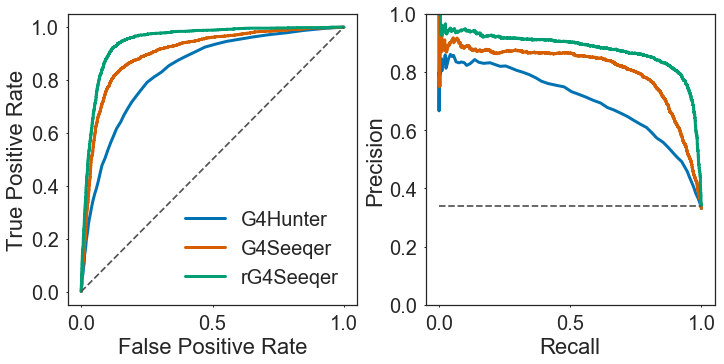

In [9]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip([g4h_pred, y_pred_dg4, y_pred], ['G4Hunter', 'G4Seeqer', 'rG4Seeqer']):
    fpr, tpr, threshold_roc = roc_curve(y_test, s)
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, linewidth=3, label=lab)
    prec, recl, threshold_pr = precision_recall_curve(y_test, s)
    axes[1].plot(recl, prec, linewidth=3)
axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[1].plot([0, 1], [prec[0], prec[0]], color='#555555', ls='--')
axes[1].set_ylim([0, 1])
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('figures/rG4seeqer_test_set_roc_pr.svg')
plt.show()

In [10]:
g4rnadb = pd.read_excel(
    'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5870565/bin/sup_table1_btx498.xls',
    header=1,
    names=['gene', 'identifier', 'length', 'seq', 'ref', 'g4', 'cCcG', 'g4h', 'g4rna_screener'],
).drop(['ref', 'cCcG'], axis=1)
g4rnadb = pd.concat([g4rnadb.iloc[:328], g4rnadb.iloc[531:]])
g4rnadb.seq = g4rnadb.seq.str.upper().str.replace('U', 'T')
g4rnadb = g4rnadb[g4rnadb.length <= 128]
g4rnadb.g4 = g4rnadb.g4.map({'True': 1, 'False': 0})
g4rnadb.head()

,gene,identifier,length,seq,g4,g4h,g4rna_screener
0,TERRA,G6C,21,GGGTTAGGCTTAGGGTTAGGG,1,1.42857,0.996036
1,TERRA,G4C,21,GGGTTACGGTTAGGGTTAGGG,1,1.42857,0.996658
2,TERRA,G6U,21,GGGTTAGGTTTAGGGTTAGGG,1,1.47619,0.975981
3,TERRA,G4U,21,GGGTTATGGTTAGGGTTAGGG,1,1.47619,0.959607
4,TERRA,G6A,21,GGGTTAGGATTAGGGTTAGGG,1,1.47619,0.996106


In [11]:
len(g4rnadb)

347

In [12]:
rg4seeqer_g4rnadb_preds = []
dg4seeqer_g4rnadb_preds = []
for _ in range(100):
    seq_ohe = np.asarray([one_hot_sequence(seq, pad='random') for seq in g4rnadb.seq])
    rg4seeqer_g4rnadb_preds.append(rg4seeqer.predict(seq_ohe).squeeze())
    dg4seeqer_g4rnadb_preds.append(dg4seeqer.predict(seq_ohe).squeeze())
g4rnadb['rg4seeqer'] = np.mean(rg4seeqer_g4rnadb_preds, axis=0)
g4rnadb['dg4seeqer'] = np.mean(dg4seeqer_g4rnadb_preds, axis=0)

0.915996276843
0.825011634865
0.876338009441


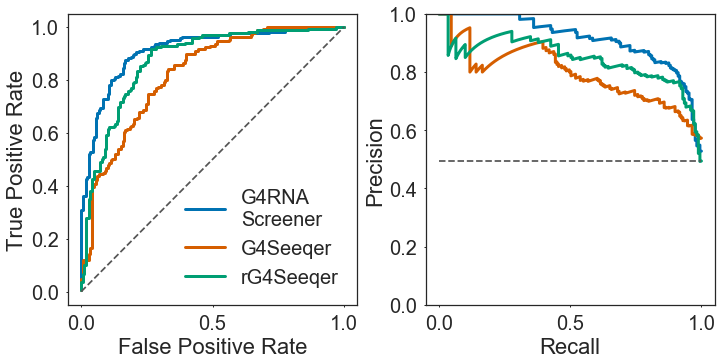

In [13]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip(['g4rna_screener', 'dg4seeqer', 'rg4seeqer'],
                  ['G4RNA\nScreener', 'G4Seeqer', 'rG4Seeqer']):
    s = g4rnadb[s]
    fpr, tpr, threshold_roc = roc_curve(g4rnadb['g4'], s)
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, linewidth=3, label=lab)
    prec, recl, threshold_pr = precision_recall_curve(g4rnadb['g4'], s)
    axes[1].plot(recl, prec, linewidth=3)
axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[1].plot([0, 1], [prec[0], prec[0]], color='#555555', ls='--')
axes[1].set_ylim([0, 1])
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('figures/rG4seeqer_g4rna_set_roc_pr.svg')
plt.show()

In [75]:
sum(1 - g4rnadb.g4)

178

In [15]:
rg4seeqer.save('../g4seeqer/data/rg4seeqer_weights.h5')